<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/LatentSpaceGifMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-cv==0.6.0 -q
!pip install -U tensorflow -q
!pip install keras-core -q

from textwrap import wrap
import os
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras
from keras_core import ops
from PIL import Image
from IPython.display import Image as IImage
import math

def export_as_gif(filename, images, frames_per_second=30, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

def downsample(images, half=0.5):
  half = 0.5
  down_size = []
  for i in range(0, len(images)):
    size = [int(half * s) for s in images[i].size]
    down_size.append(images[i].resize(size))
  return down_size

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.3/756.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.1 MB/s eta 0:00:00
Using TensorFlow backend
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


25/25 [==============================] - 7s 293ms/step


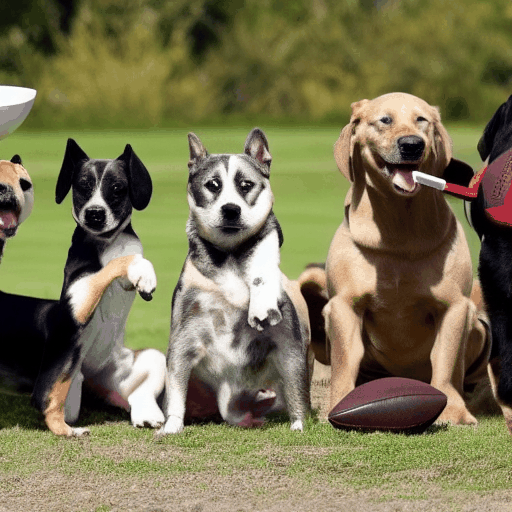

In [10]:
num_text_prompts=1 #@param { type: "integer" }
text_promp = "dogs drinking coffee and then playing football" #@param { type: "string" }
Interpolation_Walk_Text = False  #@param { type: "boolean" }
Random_Walk_Text = True #@param { type: "boolean" }
Cirular_Walk_Noise = True #@param { type: "boolean" }
steps = 12 #@param { type: "integer" }
walk_steps = 12 #@param { type: "integer" }
step_size = 0.005 #@param { type:"slider", min: 0, max: 1, step: 0.001 }
cfg_scale = 7.5  #@param { type:"slider", min: 1, max: 14, step: 0.5 }
BATCH_SIZE = 3 #@param { type: "integer" }
NUM_Diffusion_STEPS = 25 #@param { type: "integer" }
ending = ".gif"
FILENAME= "stuff" #@param { type: "string" }
save = FILENAME + ending
stores = []
seed = 12345
noise = tf.random.normal((512 // 8, 512 // 8, 4))
FPS = 2 #@param { type: "integer" }
BAND= True  #@param { type: "boolean" }



def chooseNoise():
  if Cirular_Walk_Noise:
    batch=0
    return batched_noise[batch]
  else:
    return noise




def circular_noise():
  walk_noise_x = tf.random.normal(noise.shape, dtype="float64")
  walk_noise_y = tf.random.normal(noise.shape, dtype="float64")
  walk_scale_x = ops.cos(ops.linspace(0, 2, walk_steps) * math.pi)
  walk_scale_y = ops.sin(ops.linspace(0, 2, walk_steps) * math.pi)
  noise_x = ops.tensordot(walk_scale_x, walk_noise_x, axes=0)
  noise_y = ops.tensordot(walk_scale_y, walk_noise_y, axes=0)
  noise_2 = ops.add(noise_x, noise_y)
  batched_noise = ops.split(noise_2, batches)
  return batched_noise


def random_steps(encode, walk_steps):
  store= []
  delta = ops.ones_like(encode[0]) * step_size
  if len(encode) <2:
    walked_encodings = []
    for step_index in range(walk_steps):
      walked_encodings.append(encode[0])
      encode[0] += delta
    walked_encodings = ops.stack(walked_encodings)
    batched_encodings = ops.split(walked_encodings, batches)
    return batched_encodings
  else:
    walked_encodings = []
    for _ in range(0, len(encode), 1):
      encoding_1 = encode.pop()
      for step_index in range(walk_steps):
        walked_encodings.append(encoding_1)
        encoding_1 += delta
    walked_encodings = ops.stack(walked_encodings)
    batched_encodings = ops.split(walked_encodings, batches)
    return batched_encodings

def interp_steps(encode, steps):
  store= []
  for _ in range(0, len(encode), 2):
    encoding_1 = encode.pop()
    encoding_2 = encode.pop()
    if num_text_prompts == 2:
      return ops.split(ops.linspace(encoding_1, encoding_2, steps), batches)
    store.append(ops.linspace(encoding_1, encoding_2, steps))
  if num_text_prompts==4:
    x=store.pop()
    y=store.pop()
    return ops.split(ops.reshape(ops.linspace(x, y, steps), (steps**2, 77, 768)), batches)

def text_inter(text, steps=1):
  encodings = []
  for i in range(0, len(text)):
    encodings.append(ops.squeeze(model.encode_text(text[i])))
  if len(encodings) < 2:
    if Random_Walk_Text:
      batch_walks=random_steps(encodings, steps)
      return batch_walks
    return encodings
  elif (len(encodings)%2!=0):
    raise Exception("Prompts have to be a multiple of 2")
  else:
    if Interpolation_Walk_Text:
      batch_interp=interp_steps(encodings, steps)
      return batch_interp
    elif Random_Walk_Text:
      batch_walks=random_steps(encodings, steps)
      return batch_walks
    else:
      raise Exception("Have to either choose either random walk or interpolation walk")


# Start of Application
if num_text_prompts==2  or num_text_prompts>2:
  stores = text_promp.split(sep="|")
  batch_size= BATCH_SIZE
  if num_text_prompts==2:
    batches = steps // BATCH_SIZE
    if steps%batches!=0:
      raise Exception("interpolation steps divided by batch size must be divisble by batches")
  if num_text_prompts>2:
    batches = steps**2 // BATCH_SIZE
    if (steps**2)%batches!=0:
      raise Exception("squared interpolation steps divided by batch size must be divisble by batches")
  encodings = text_inter(stores, steps)
  if Cirular_Walk_Noise:
    batched_noise=circular_noise()
else:
  stores.append(text_promp)
  batches = steps // BATCH_SIZE
  if steps%batches!=0:
    raise Exception("interpolation steps divided by batch size must be divisble by batches")
  # batch_size=1
  encodings = text_inter(stores, steps)
  if Cirular_Walk_Noise:
    batched_noise=circular_noise()

batch_size=int(tf.shape(encodings)[1])

images = []
for batch in range(batches):
  images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encodings[batch],
            batch_size=batch_size,
            num_steps=NUM_Diffusion_STEPS,
            diffusion_noise=chooseNoise(),
            unconditional_guidance_scale = 7.5,
        )
      ]

if steps > 100:
  export_as_gif(save, downsample(images), frames_per_second=FPS ,rubber_band=BAND)
else:
  export_as_gif(filename=save, images=images, frames_per_second=FPS, rubber_band=BAND)
IImage(save)